### Package Installation and Dataset<a id='top'></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing required libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
import time
from sklearn.svm import SVC
from sklearn.metrics import log_loss
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Room occupancy dataset
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Room_Occupancy_Estimation.csv')

### Data Explanation

In [ ]:
# Display the shape of the original dataframe
print(f"The shape of the ORIGINAL data is (rows, columns): {df.shape}")

# Display the first three rows of the dataframe
df.head(5)

The shape of the ORIGINAL data is (rows, columns): (10129, 19)


,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [ ]:
# Printing information about this dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

**Categorical Variables:**

1. **Date (Date):** The date when the data was recorded, in the format YYYY/MM/DD.
2. **Time (Time):** The time of the day when the data was recorded, in the format HH:MM:SS.
3. **Room Occupancy Count (Room_Occupancy_Count):** The actual number of people in the room, serving as the ground truth for occupancy.

**Numerical Variables:**

1. **Temperature (S1_Temp, S2_Temp, S3_Temp, S4_Temp):** The temperature recorded by different sensors in degrees Celsius.
2. **Light (S1_Light, S2_Light, S3_Light, S4_Light):** The light intensity measured by different sensors in Lux (a unit indicating how much light falls on a surface).
3. **Sound (S1_Sound, S2_Sound, S3_Sound, S4_Sound):** The sound level recorded by different sensors, represented in volts (output read by an Analog-to-Digital Converter).
4. **CO2 (S5_CO2):** The concentration of carbon dioxide in the room, measured in parts per million (PPM).
5. **CO2 Slope (S5_CO2_Slope):** The slope of CO2 values taken over a sliding window, indicating the rate of change in CO2 concentration.
6. **PIR (S6_PIR, S7_PIR):** Binary values from Passive Infrared sensors indicating motion detection (0 for no motion, 1 for motion detected).

### Data Preprocessing & Exploratory Data Analysis <a id='top'></a>

##### Handling Duplicate & missing values

In [ ]:
# Shape of the dataframe before removing duplicate entries
print(f"The shape of the dataset before dropping duplicates: {df.shape}")

# Remove duplicates from the dataset
df.drop_duplicates(inplace=True)

# Shape of the dataframe after removing duplicate entries
print(f"The shape of the dataset after dropping duplicates: {df.shape}")

The shape of the dataset before dropping duplicates: (10129, 19)
The shape of the dataset after dropping duplicates: (10129, 19)


In [ ]:
# Check if the dataframe has any null or missing values
has_null = df.isnull().values.any()

print("Does dataframe contains null value?: ", has_null)

Does dataframe contains null value?:  False


##### Removing non-periodic features


In [ ]:
# Getting all features in the dataset
df.columns

Index(['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count'],
      dtype='object')

Here, we can see that Date can add external complexity in model learning. Furthermore, it can be possibility of overfitting because of Date especially if the dataset covers a limited period and the model mistakenly learns patterns specific to that period rather than general trends.

In [ ]:
# Delete Date feature because of the non periodic nature
df = df.drop('Date', axis=1)

In [ ]:
print("Columns after removal:", df.columns)
df.head()

Columns after removal: Index(['Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count'],
      dtype='object')


,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


In [ ]:
print("After removing Date, duplicate entries: ", df[df.duplicated()].shape[0])

After removing Date, duplicate entries:  0


Upon removal of the 'Date' column, it was observed that the dataset still maintains its uniqueness, meaning there are no duplicate entries.

The 'Time' feature plays a significant role in the analysis, especially in understanding the pattern of room occupancy throughout the day.

##### Cyclic Encoding (Sine-Cosine Transformation) of Time feature


**Cyclic encoding**

Cyclic encoding, particularly using sine and cosine transformations, is an effective method for handling cyclical features like time. In many data, time is a crucial feature as it often carries important patterns.

In room occupancy estimation, the time of day significantly influences occupancy patterns. Traditional numerical encoding of time (e.g., representing 23:00 as 23 or 2300) fails to capture the cyclical nature of time - for example, it doesn't inherently reflect that 23:00 is close to 00:00.

Cyclic encoding through sine and cosine transformations overcomes this limitation. It represents each time point on a circle, maintaining the continuity of time - so midnight and late night are close to each other, preserving the cyclical nature of time.

In [ ]:
# Convert Time to datetime type
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

In [ ]:
# Extract hours, minutes, and seconds
df['hour'] = df['Time'].dt.hour
df['minute'] = df['Time'].dt.minute
df['second'] = df['Time'].dt.second

In [ ]:
# Apply sine and cosine transformations on Time feature
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)
df['sin_minute'] = np.sin(2 * np.pi * df['minute'] / 60)
df['cos_minute'] = np.cos(2 * np.pi * df['minute'] / 60)
df['sin_second'] = np.sin(2 * np.pi * df['second'] / 60)
df['cos_second'] = np.cos(2 * np.pi * df['second'] / 60)

In [ ]:
# Drop columns - Time, hour, minute, second
df = df.drop(['Time', 'hour', 'minute', 'second'], axis=1)

In [ ]:
# Getting all features in the dataset
df.columns

Index(['S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light', 'S2_Light',
       'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound', 'S4_Sound',
       'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Room_Occupancy_Count',
       'sin_hour', 'cos_hour', 'sin_minute', 'cos_minute', 'sin_second',
       'cos_second'],
      dtype='object')

In [ ]:
print("Shape of dataset: ", df.shape)
print("After encoding Time into Cyclic manner, duplicate entries: ", df[df.duplicated()].shape[0])

Shape of dataset:  (10129, 23)
After encoding Time into Cyclic manner, duplicate entries:  0


##### Data description and distribution by features

In [ ]:
# see the static of all numerical column
df.describe().T

,count,mean,std,min,25%,50%,75%,max
S1_Temp,10129.0,25.454012,0.351351,24.940000,25.190000,2.538000e+01,25.630000,26.380000
S2_Temp,10129.0,25.546059,0.586325,24.750000,25.190000,2.538000e+01,25.630000,29.000000
S3_Temp,10129.0,25.056621,0.427283,24.440000,24.690000,2.494000e+01,25.380000,26.190000
S4_Temp,10129.0,25.754125,0.356434,24.940000,25.440000,2.575000e+01,26.000000,26.560000
S1_Light,10129.0,25.445059,51.011264,0.000000,0.000000,0.000000e+00,12.000000,165.000000
S2_Light,10129.0,26.016290,67.304170,0.000000,0.000000,0.000000e+00,14.000000,258.000000
S3_Light,10129.0,34.248494,58.400744,0.000000,0.000000,0.000000e+00,50.000000,280.000000
S4_Light,10129.0,13.220259,19.602219,0.000000,0.000000,0.000000e+00,22.000000,74.000000
S1_Sound,10129.0,0.168178,0.316709,0.060000,0.070000,8.000000e-02,0.080000,3.880000
S2_Sound,10129.0,0.120066,0.266503,0.040000,0.050000,5.000000e-02,0.060000,3.440000


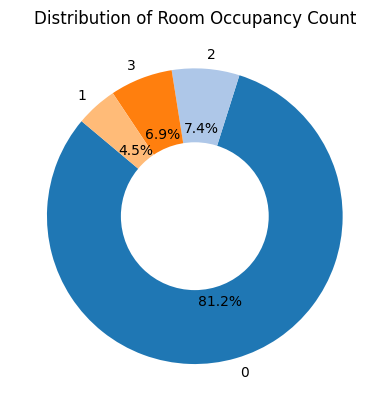

In [ ]:
def plot_donut(data_counts, title):
  fig, ax = plt.subplots()
  ax.pie(data_counts, labels=data_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
  ax.set_aspect('equal')

  centre_circle = plt.Circle((0,0),0.50,fc='white')
  fig.gca().add_artist(centre_circle)

  plt.title(title)
  plt.show()

# Plotting donut for room occupancy count
room_occupancy_counts = df['Room_Occupancy_Count'].value_counts()
plot_donut(room_occupancy_counts, 'Distribution of Room Occupancy Count')

Here, we can see that dataset distribution by numbers of occupied rooms is highly imbalanced as chances of empty room is very high (more than 80%).

Firstly, we will explore 3 types of sensor data (Temperature, Light and Sound)
by visualizing them and understanding their distribution.

In [ ]:
def plot_kde_for_columns(data, columns, title, color):
    fig, ax = plt.subplots(1, len(columns), figsize=(13, 5))
    ax = ax.flatten()

    for index, col in enumerate(columns):
        sns.kdeplot(data=data, ax=ax[index], x=col, fill=True, color=color)
        ax[index].set_xticks([])
        ax[index].set_yticks([])
        ax[index].set_xlabel(col)

    fig.tight_layout()
    plt.suptitle(title, va='baseline')
    plt.show()

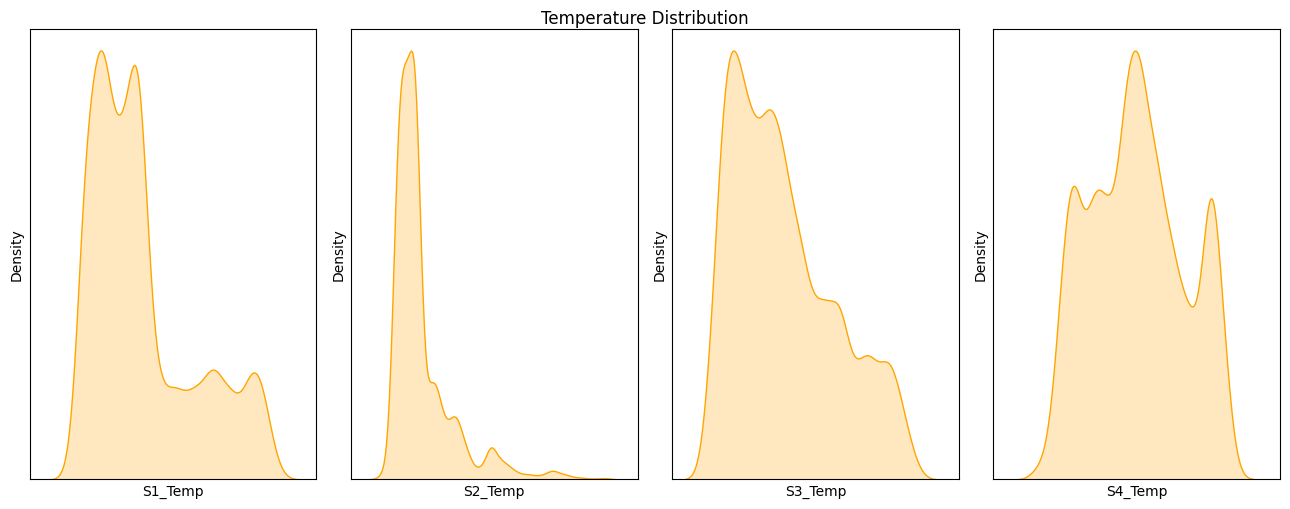

In [ ]:
# Comparison of distribution of Temperature sensors data
plot_kde_for_columns(data=df, columns=["S1_Temp", "S2_Temp", "S3_Temp", "S4_Temp"], title="Temperature Distribution", color="orange")

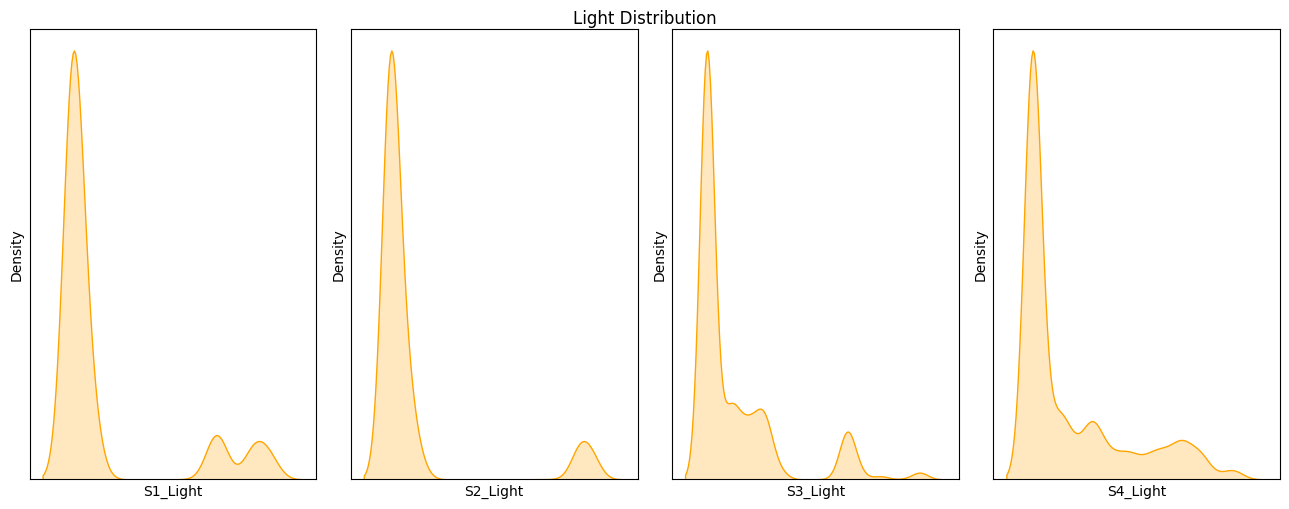

In [ ]:
# Comparison of distribution of Light sensors data
plot_kde_for_columns(data=df, columns=["S1_Light", "S2_Light", "S3_Light", "S4_Light"], title="Light Distribution", color="orange")

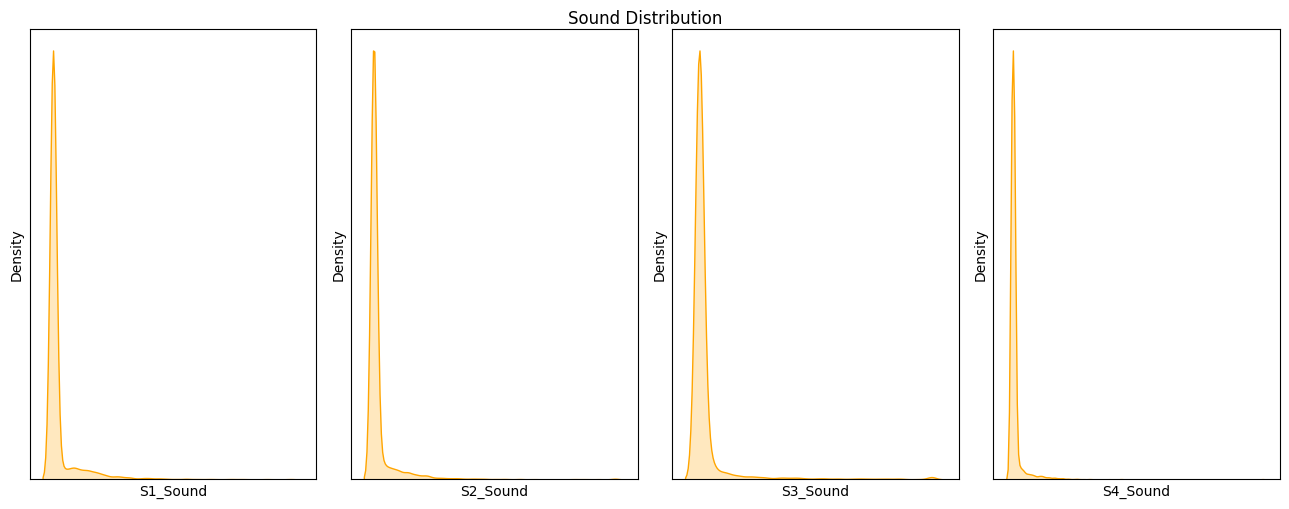

In [ ]:
# Comparison of distribution of Sound sensors data
plot_kde_for_columns(data=df, columns=["S1_Sound", "S2_Sound", "S3_Sound", "S4_Sound"], title="Sound Distribution", color="orange")

Here, we can see that all this data are Positively Skewed, which also prooved from description of the data as it has higher maximum values compare to their mean and median.

We have to analyse further features and have to handle outliers.

In [ ]:
def plot_boxplots(data):
    plt.figure(figsize=(12, 8))

    palette = {col: np.random.rand(3,) for col in data.select_dtypes(include=np.number).columns}
    sns.boxplot(data=data.select_dtypes(include=np.number), orient="h", palette=palette)

    plt.show()

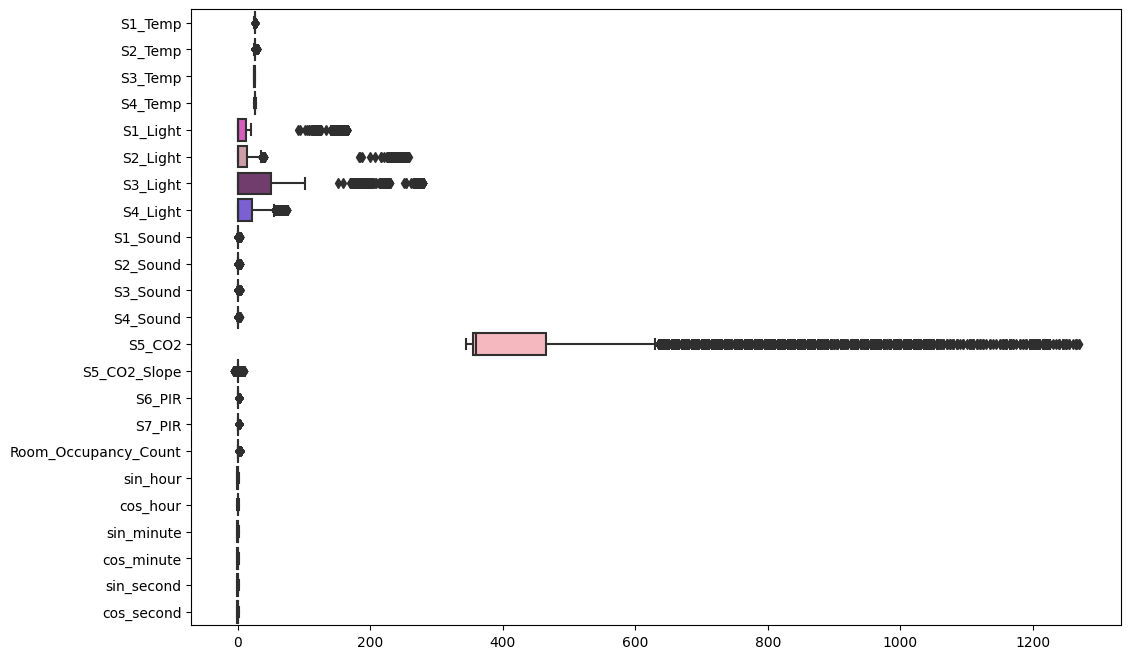

In [ ]:
# Full box plot visualization of dataset
plot_boxplots(df)

From above all visual information, we can finalize that there are mainly Light and CO2 level features contains higer amount of outliers. Before processing them, we have to check corelation of them with target variables.

##### Feature understanding having outliers & symptomatic analysis

From above graph, we can consider following features to analyse according to their outliers.

1. **S1_Light**
2. **S2_Light**
3. **S3_Light**
4. **S4_Light**
5. **S5_CO2**

Let's visualize in-depth for this features and make decision about their outliers.

In [ ]:
def plot_feature_to_the_target(data, features_list, target):
    n_rows = len(features_list) // 4 + int(len(features_list) % 4 > 0)
    n_cols = min(len(features_list), 4)

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 3.75, n_rows * 3), squeeze=False)

    axes_flat = axes.flatten()

    for idx, feat in enumerate(features_list):
        ax = axes_flat[idx]
        sns.boxplot(x=target, y=feat, data=data, ax=ax)
        ax.set_xlabel('')
        ax.set_ylabel(feat)

    for idx in range(len(features_list), n_rows * n_cols):
        axes_flat[idx].set_visible(False)

    fig.suptitle('Features Relationship with the Target Variable', size=20)
    plt.tight_layout()
    plt.show()

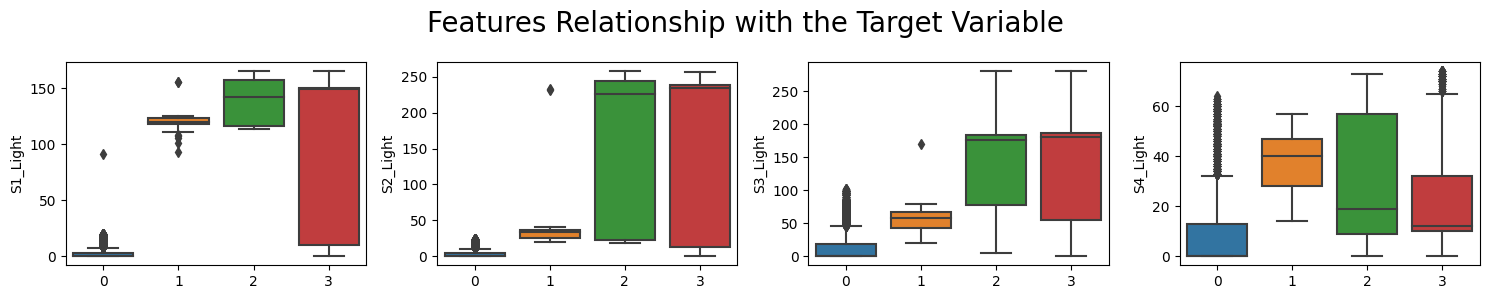

In [ ]:
# Light features box plot
features_list = ['S1_Light', 'S2_Light', 'S3_Light', 'S4_Light']
plot_feature_to_the_target(df, features_list, 'Room_Occupancy_Count')

**Light feature**

Outliers in light readings could represent actual usage patterns, such as lights being turned on for meetings, cleaning, or other activities. Therefore, they provide valuable insights into occupancy patterns and should not be discarded without careful consideration.

From individual distribution graph of light features, we can see that data are completly positive skewed. However, we can compare it with target feature (Count of room occupancy) and can found that it can be useful information.

Here's a general breakdown of lux levels for different environments:

* **50 lux:** A fairly dimly lit space, akin to a family living room in the evening.
* **100 lux:** The minimum level recommended for easy visual tasks or areas with infrequent use.
* **300-500 lux:** Standard office lighting or workspaces where visual tasks are carried out.
* **800 lux:** More demanding visual tasks like drawing or detailed mechanical work.

This information defines that having extreme value of Light feature is significal and provide valuable information. To summarize, here we are not removing outliers from Light features.

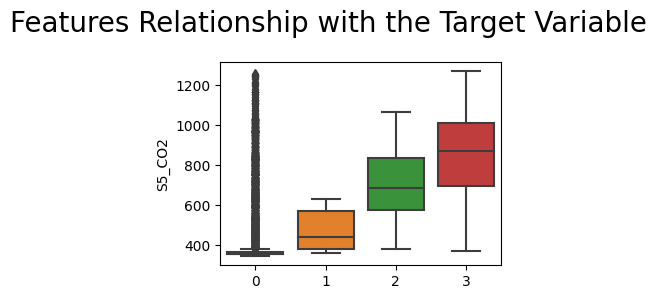

In [ ]:
# S5_CO2 features box plot
plot_feature_to_the_target(df, ['S5_CO2'], 'Room_Occupancy_Count')

**General CO2 level:**

* **Normal Outdoor Air Level (400 ppm):** This is the normal level of CO2 in outdoor air and is used as a baseline for comparison.
* **Indoor Levels (400 - 1,100 ppm) with Good Ventilation:** These levels are typical for indoor environments with good air circulation and proper ventilation. Low CO2 levels in a sealed and occupied building may indicate that there is excessive ventilation, which could lead to energy inefficiency.
* **OSHA/ASHRAE Recommended Maximum (1,100 ppm):** This is the upper limit recommended by organizations such as OSHA (Occupational Safety and Health Administration) and ASHRAE (American Society of Heating, Refrigerating and Air-Conditioning Engineers) for indoor air quality in a closed room.
* **Poor Air Quality (> 1,200 ppm):** At this point, air quality is considered poor, and ventilation is required to improve the indoor air quality.
* **Health Effects (2,000 ppm):** CO2 concentrations at this level can cause noticeable adverse health effects, such as increased drowsiness, headaches, reduced concentration, and a higher likelihood of transmission of respiratory viruses.


Considering these standards, the CO2 levels in the dataset should not be hastily dismissed as outliers solely based on their numerical value. These readings could be critical in assessing the ventilation needs of a space, the comfort and productivity of the occupants, and the potential for spreading illness. They can provide valuable insights. Hence, we will not remove outliers from this feature as well.


**Outlier Handling Summary:**

Throughout the dataset, Lights and CO2 features consist most of the outliers. However, because of their valuability and correlation with target variable, we are not removing outliers from dataset.


##### Identifying Multicollinearity

To identify multicollinearity, we looking at a correlation matrix and then move on to more advanced statistics like Variance Inflation Factor (VIF).

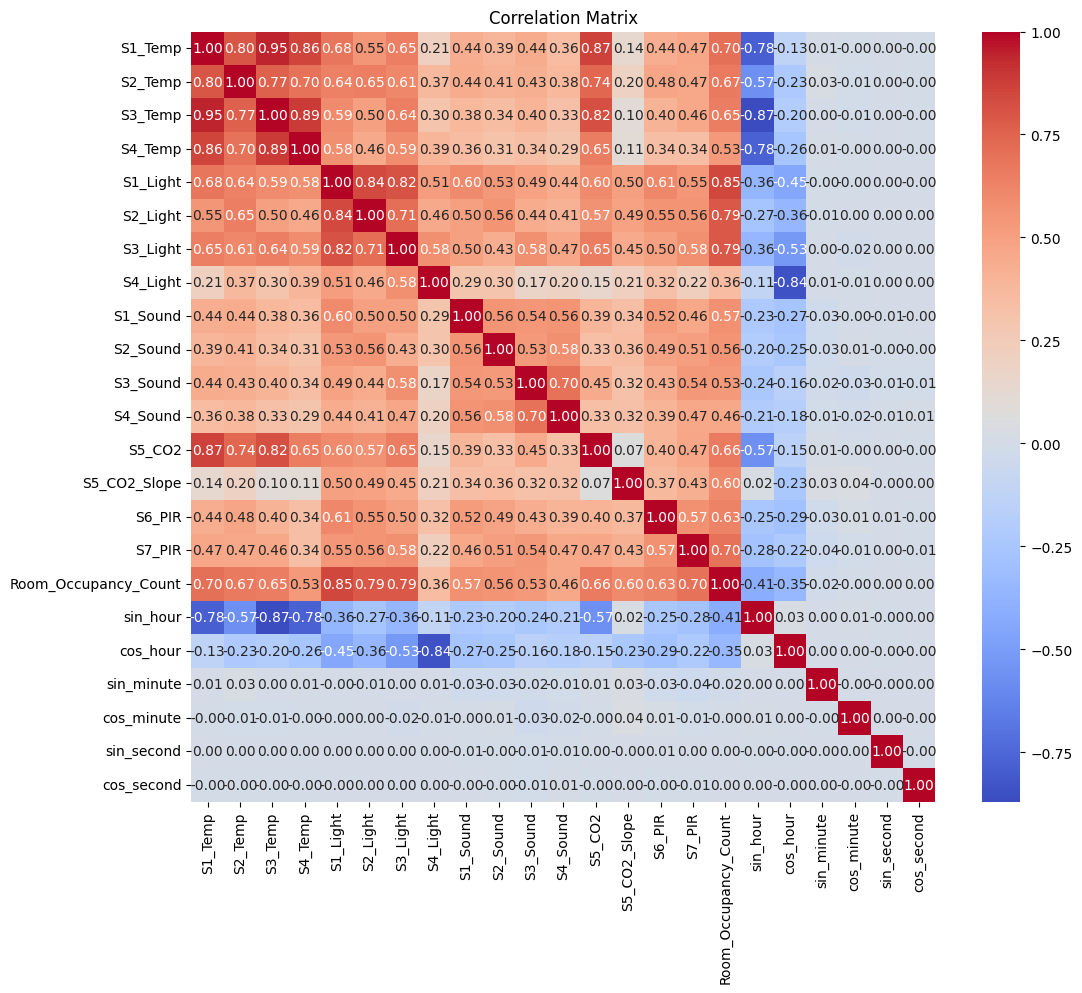

In [ ]:
# 1. Correlation Matrix
# Calculate the correlation matrix
corr_matrix = df.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Define a threshold for identifying highly correlated features
threshold = 0.8

# Identify and print pairs of highly correlated features
print("Pairs of highly correlated features:")
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            print(f"{corr_matrix.columns[i]} and {corr_matrix.columns[j]} have a correlation of {corr_matrix.iloc[i, j]:.2f}")

Pairs of highly correlated features:
S3_Temp and S1_Temp have a correlation of 0.95
S4_Temp and S1_Temp have a correlation of 0.86
S4_Temp and S3_Temp have a correlation of 0.89
S2_Light and S1_Light have a correlation of 0.84
S3_Light and S1_Light have a correlation of 0.82
S5_CO2 and S1_Temp have a correlation of 0.87
S5_CO2 and S3_Temp have a correlation of 0.82
Room_Occupancy_Count and S1_Light have a correlation of 0.85
sin_hour and S3_Temp have a correlation of -0.87
cos_hour and S4_Light have a correlation of -0.84


A correlation matrix provides a pairwise correlation coefficient for each variable in the dataset, which can highlight potential multicollinearity if two or more features have high correlations with one another.

In [ ]:
# Hypothetical features list
features_list = df.select_dtypes(include=[np.number]).columns.tolist()

# Add a constant for the intercept
X = add_constant(df[features_list])

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)

# Remove features with VIF > 10
features_to_remove = vif_data[vif_data["VIF"] > 10]["feature"].tolist()
print("\n\nFeatures to remove: ", features_to_remove)

                 feature           VIF
0                  const  85958.965206
1                S1_Temp     30.670493
2                S2_Temp      4.256917
3                S3_Temp     41.920350
4                S4_Temp      7.212099
5               S1_Light     11.174537
6               S2_Light      5.594150
7               S3_Light      6.826218
8               S4_Light      7.402386
9               S1_Sound      2.102474
10              S2_Sound      2.247463
11              S3_Sound      2.668339
12              S4_Sound      2.365226
13                S5_CO2      9.274769
14          S5_CO2_Slope      2.547852
15                S6_PIR      2.017082
16                S7_PIR      2.369164
17  Room_Occupancy_Count      9.924600
18              sin_hour      8.448540
19              cos_hour      4.492229
20            sin_minute      1.014912
21            cos_minute      1.008184
22            sin_second      1.000415
23            cos_second      1.000729


Features to remove:  ['

From above both statistical procedure, we can conclude that features S1_Temp, S3_temp and S1_Light have high correlation and collinearity. However, it have same correlation with target variables. Hence, we can not conclude about reducing dimensionality of the dataset.

In [ ]:
deleted_feature = ['sin_minute', 'cos_minute', 'sin_second','cos_second']
df = df.drop(deleted_feature, axis=1)

### Train and Test Split<a id='top'></a>

In [ ]:
X = df.drop('Room_Occupancy_Count', axis=1)
y = df['Room_Occupancy_Count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Distribution in training set:\n", y_train.value_counts(normalize=True))
print("Distribution in test set:\n", y_test.value_counts(normalize=True))

Distribution in training set:
 0    0.812292
2    0.073923
3    0.068493
1    0.045292
Name: Room_Occupancy_Count, dtype: float64
Distribution in test set:
 0    0.812438
2    0.073544
3    0.068608
1    0.045410
Name: Room_Occupancy_Count, dtype: float64


### SMOT Analysis for handling imbalanced data<a id='top'></a>

In [ ]:
def plot_fetuare_distribution(df, feature_name):
  sns.distplot(df[feature_name], hist=True, kde=True,
              bins=int(180/5), color='darkblue',
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 4})

  plt.title(f'Skewness of {feature_name} Data')
  plt.xlabel(f'{feature_name}')
  plt.ylabel('Density')
  plt.show()

<ipython-input-35-2bbaad989d8e>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[feature_name], hist=True, kde=True,


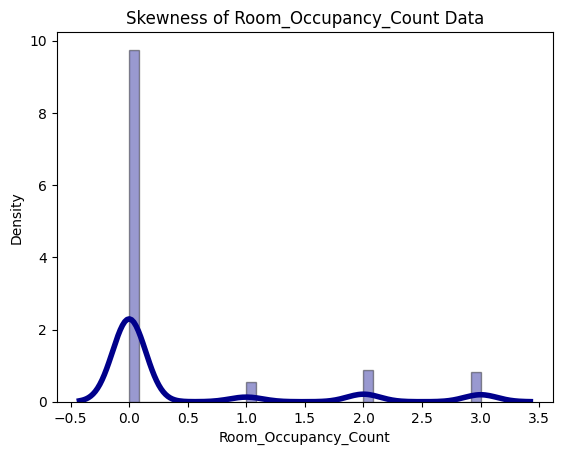

In [ ]:
column_name ="Room_Occupancy_Count"
plot_fetuare_distribution(df, column_name)

Using SMOTE (Synthetic Minority Over-sampling Technique) is effective for countering the imbalance in a target variable, like "Bankrupt". It helps reduce model bias by generating synthetic samples for the minority class, balancing the dataset.

In [ ]:
def oversample_data(X, y):
    class_distribution = Counter(y)
    print("Original class distribution:", class_distribution)

    max_class_count = max(class_distribution.values())
    resampling_strategy = {cls: int(max_class_count * 0.5) for cls in class_distribution}
    resampling_strategy = {cls: max(count, class_distribution[cls]) for cls, count in resampling_strategy.items()}

    smote = SMOTE(sampling_strategy=resampling_strategy)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

    print("New class distribution:", Counter(y_train_smote))

    return X_train_smote, y_train_smote

# Apply oversampling to unscaled train and test data
X_train_resampled, y_train_resampled = oversample_data(X_train, y_train)

Original class distribution: Counter({0: 6582, 2: 599, 3: 555, 1: 367})
New class distribution: Counter({0: 6582, 2: 3291, 3: 3291, 1: 3291})


In [ ]:
# Standardization of the final re-sampled dataset
scaler = StandardScaler()
X_train_unbalanced_scaled = scaler.fit_transform(X_train)
X_train_balanced_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

### Principle Component Analysis (PCA)<a id='top'></a>

In [ ]:
def apply_pca_and_transform(X_train, X_test, n_components=None):
    pca = PCA()
    pca.fit(X_train)

    # Plotting the Cumulative Summation of the Explained Variance
    plt.figure(figsize=(8, 4))
    plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
             np.cumsum(pca.explained_variance_ratio_))
    plt.title('Explained Variance by Different Principal Components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.show()

    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.fit_transform(X_test)

    columns = [f'PC{i+1}' for i in range(X_train_pca.shape[1])]
    df_train_pca = pd.DataFrame(X_train_pca, columns=columns)
    df_test_pca = pd.DataFrame(X_test_pca, columns=columns)

    return df_train_pca, df_test_pca

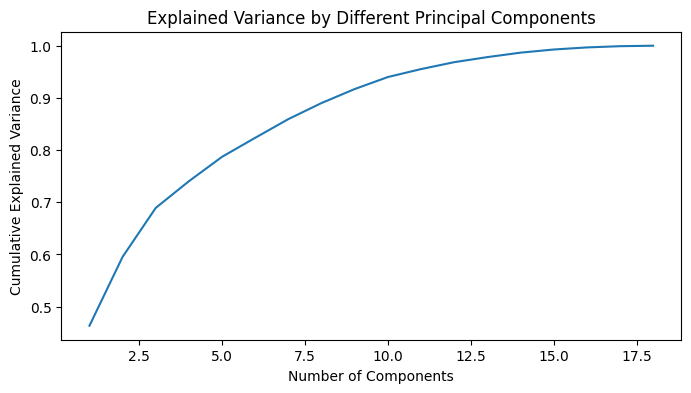

In [ ]:
X_train_pca, X_test_pca = apply_pca_and_transform(X_train_balanced_scaled, X_test_scaled, n_components=3)

In [ ]:
def visualize_pca_components(data, title_prefix="PCA Comparison"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, ax in enumerate(axes):
        pca1, pca2 = (i % 3, (i + 1) % 3)

        scatter = ax.scatter(data.iloc[:, pca1], data.iloc[:, pca2], cmap='viridis', edgecolor='k', s=20)
        ax.set_xlabel(f'PCA {pca1 + 1}')
        ax.set_ylabel(f'PCA {pca2 + 1}')
        ax.set_title(f'{title_prefix}: PCA {pca1 + 1} vs PCA {pca2 + 1}')

    fig.colorbar(scatter, ax=axes.ravel().tolist(), label=f'Target: PCA {pca2 + 1}')
    plt.show()

<ipython-input-43-cbeef26046cc>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(data.iloc[:, pca1], data.iloc[:, pca2], cmap='viridis', edgecolor='k', s=20)


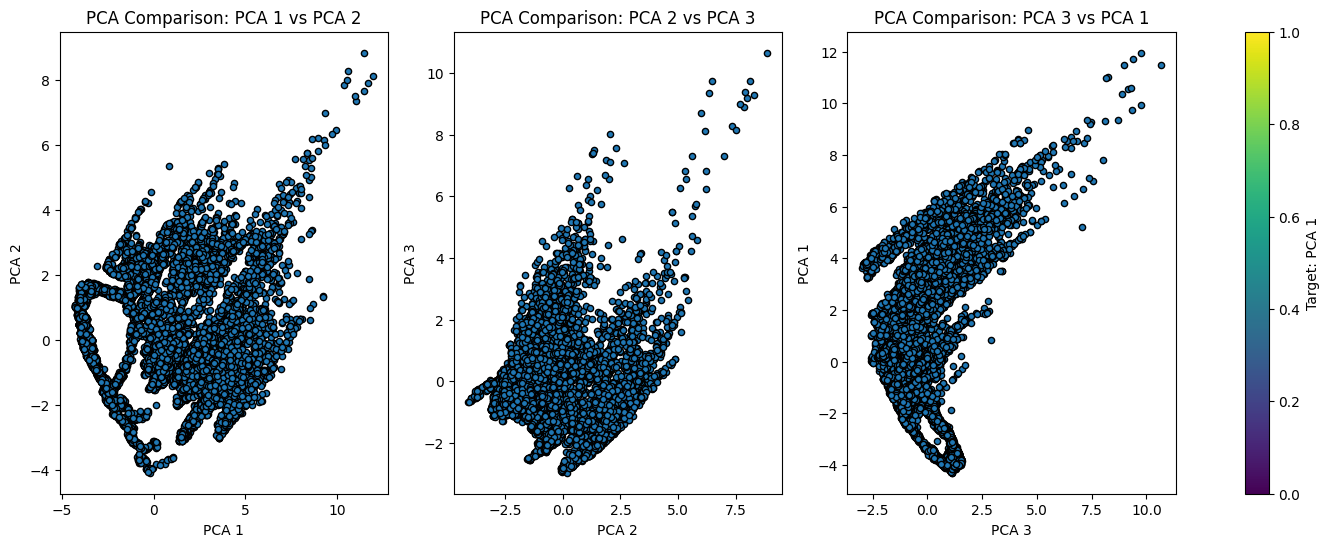

In [ ]:
# Plotting PCA graph
visualize_pca_components(X_train_pca)

<ipython-input-43-cbeef26046cc>:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(data.iloc[:, pca1], data.iloc[:, pca2], cmap='viridis', edgecolor='k', s=20)


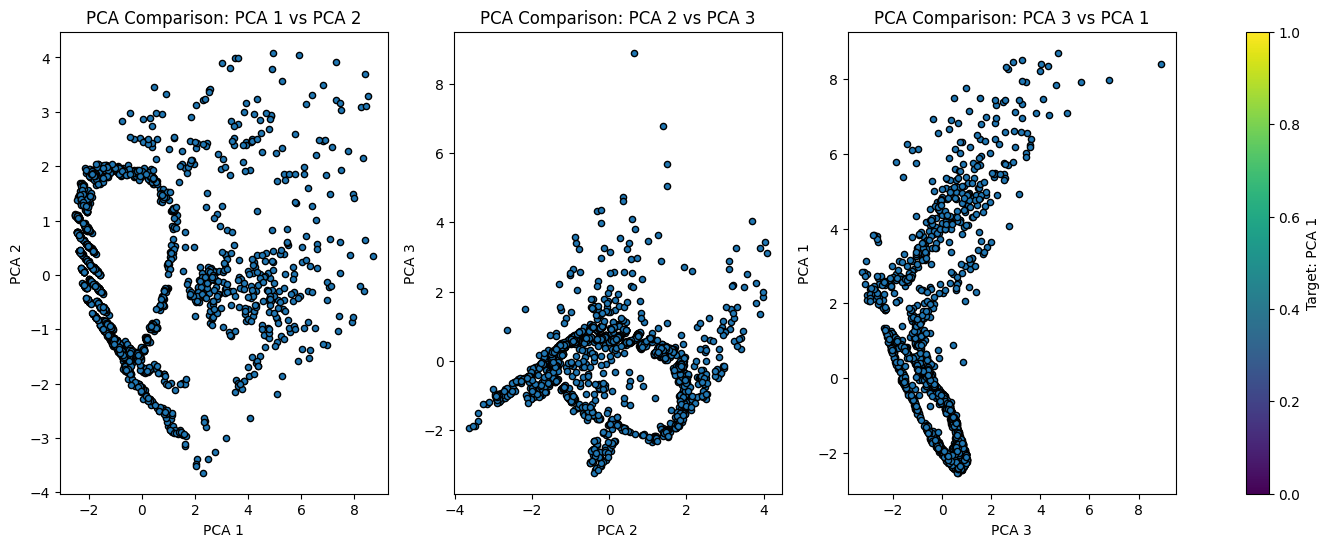

In [ ]:
# Plotting PCA graph for test data
visualize_pca_components(X_test_pca)

### Model implementation and Evaluation comparison<a id='top'></a>

In [ ]:
def display_metrics(metrics):
    table = PrettyTable()
    table.field_names = ["Metric", "Value"]
    for key, value in metrics.items():
        table.add_row([key, value])

    print(table)

In [ ]:
def plot_multiclass_roc(model, X_test, y_test, n_classes):
    # Binarize the output
    y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Predict probabilities
    y_pred_proba = model.predict_proba(X_test)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot all ROC curves
    plt.figure(figsize=(6, 3))

    colors = ['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    Evaluates the given model on the test set and returns various metrics.

    :param model: The trained machine learning model
    :param X_train: Training set features
    :param y_train: Training set target variable
    :param X_test: Test set features
    :param y_test: Test set target variable
    :return: Dictionary containing various evaluation metrics
    """
    # Measure the training time
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time

   # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    # Binarize y_test for multi-class AUC-ROC calculation
    classes = np.unique(y_train)
    y_test_binarized = label_binarize(y_test, classes=classes)

    # Metrics
    metrics = {
        "Training Time (seconds)": training_time,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred, average='macro'),
        "Precision": precision_score(y_test, y_pred, average='macro', zero_division=True),
        "Recall": recall_score(y_test, y_pred, average='macro'),
        "AUC-ROC": roc_auc_score(y_test_binarized, y_pred_proba, multi_class='ovr'),
        "Log Loss (Cross Entropy)": log_loss(y_test_binarized, y_pred_proba)
    }

    plot_multiclass_roc(model, X_test, y_test, n_classes=4)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    display_metrics(metrics)

    return metrics


In [ ]:
model_metrics = {}

In [ ]:
pd.DataFrame(model_metrics).T.to_csv("result.csv", encoding="utf-8", header=True, index=True)

#### Support Vector Machine

##### SVM with Principle Component Analysis & SMOTE

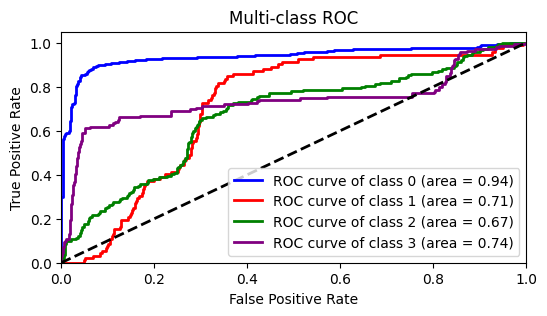

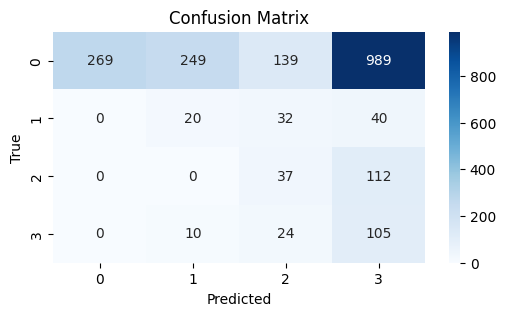

+--------------------------+---------------------+
|          Metric          |        Value        |
+--------------------------+---------------------+
| Training Time (seconds)  |  9.371716976165771  |
|         Accuracy         | 0.21273445212240868 |
|         F1 Score         |  0.1836517324730536 |
|        Precision         | 0.32885925233891455 |
|          Recall          |  0.3461339059772338 |
|         AUC-ROC          |  0.7666259119270002 |
| Log Loss (Cross Entropy) |  2.531649058012835  |
+--------------------------+---------------------+


In [ ]:
svm_clf = SVC(kernel='rbf', probability=True, random_state=123)
model_metrics['SVM_PCA'] = evaluate_model(svm_clf, X_train_pca, y_train_resampled, X_test_pca, y_test)

**Result Analysis**

1. **Training Time (9.37 seconds):**

  This is the time taken to train your SVM model. The training time seems reasonable, but this depends on the size of your dataset and the complexity of the model. If training time is a critical factor (for larger datasets or real-time applications), you might need to explore ways to optimize it.

2. **Accuracy (21.27%):**

  Accuracy is the proportion of true results (both true positives and true negatives) among the total number of cases examined. An accuracy of around 21% is quite low, indicating that the model correctly predicts the class only about a quarter of the time. This might suggest that the model is not very effective for this particular task or dataset.

3. **F1 Score (18.36%):**

  The F1 Score is the harmonic mean of Precision and Recall. It is a measure of a model's accuracy in terms of both precision and recall. A low F1 score indicates that the model has poor precision and/or recall. This could be a result of a highly imbalanced dataset or a model that doesn't fit the data well.

4. **Precision (32.88%):**

  Precision is the ratio of correctly predicted positive observations to the total predicted positives. The relatively low precision suggests that there are a significant number of false positives – instances where the model incorrectly predicts a positive class.

5. **Recall (34.61%):**

  Recall (or sensitivity) is the ratio of correctly predicted positive observations to all observations in the actual class. The recall being slightly higher than precision suggests that the model is slightly better at identifying true positives, but it still misses a lot of actual positive cases.

6. **AUC-ROC (76.66%):**

  The AUC-ROC score is a performance measurement for the classification problems at various thresholds settings. ROC is a probability curve, and AUC represents the degree of separability. An AUC-ROC of 76.66% is relatively high, which might seem contradictory given the low accuracy and F1 score. This could indicate that the model is better at ranking predictions than making binary class predictions.

7. **Log Loss (Cross Entropy) (2.53):**

  Log Loss measures the performance of a classification model where the prediction input is a probability value between 0 and 1. A lower log loss means a better model. A log loss of 2.53 is relatively high, indicating that the model's predicted probabilities are quite far from the actual values.

##### SVM with unbalanced dataset

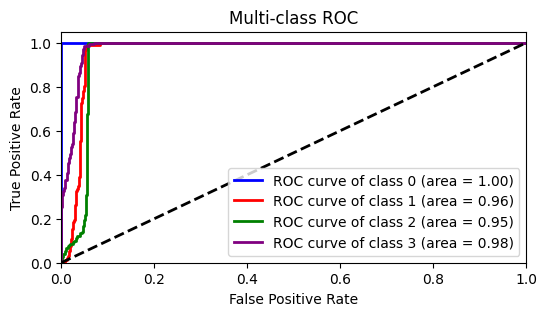

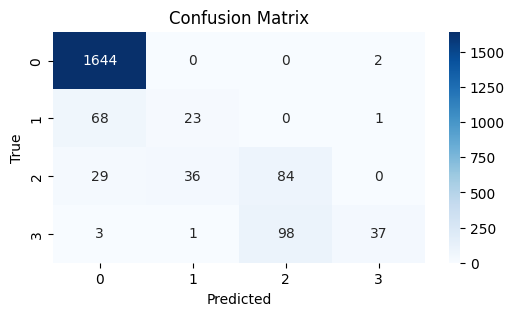

+--------------------------+--------------------+
|          Metric          |       Value        |
+--------------------------+--------------------+
| Training Time (seconds)  | 2.1291019916534424 |
|         Accuracy         | 0.8825271470878578 |
|         F1 Score         | 0.5483759436729579 |
|        Precision         | 0.6781330863326276 |
|          Recall          | 0.5196825931981954 |
|         AUC-ROC          | 0.972873493882023  |
| Log Loss (Cross Entropy) | 0.3381065018295163 |
+--------------------------+--------------------+


In [ ]:
svm_clf_balanced = SVC(kernel='rbf', probability=True, random_state=123)
model_metrics['SVM_W/O_PCA_IMBALANCED'] = evaluate_model(svm_clf_balanced, X_train_unbalanced_scaled, y_train, X_test_scaled, y_test)

**Result Analysis**

1. **Training Time (2.13 seconds):**

  The training time is relatively short, which is beneficial, especially for iterative processes like model tuning or when working with larger datasets.

2. **Accuracy (88.25%):**

  The model achieves a high accuracy rate, correctly predicting the class nearly 88% of the time. While this appears impressive, accuracy can be misleading in unbalanced datasets, as models can be biased towards the majority class.

3. **F1 Score (54.83%):**

  The F1 Score, which balances precision and recall, is significantly lower than the accuracy. This discrepancy suggests that the model's performance is not consistent across all classes, which is a common issue in unbalanced datasets.

4. **Precision (67.81%):**

  Precision is relatively high, indicating that when the model predicts a class, it is correct about 67% of the time. However, given the unbalanced nature of the dataset, this might be primarily driven by the majority class.

5. **Recall (51.97%):**

  The recall is moderate, meaning the model correctly identifies 52% of actual positive cases across all classes. In the context of an unbalanced dataset, this suggests that the model might be missing a significant number of positive instances in the minority classes.

6. **AUC-ROC (97.28%):**

  A high AUC-ROC score indicates good separability; the model can distinguish between classes well. However, this score should be interpreted cautiously in unbalanced datasets, as it can sometimes be overly optimistic.

7. **Log Loss (Cross Entropy) (0.338):**

  The low log loss value suggests that the model's probability predictions are generally close to the true values, which is a good sign of model performance.

##### SVM with balanced dataset

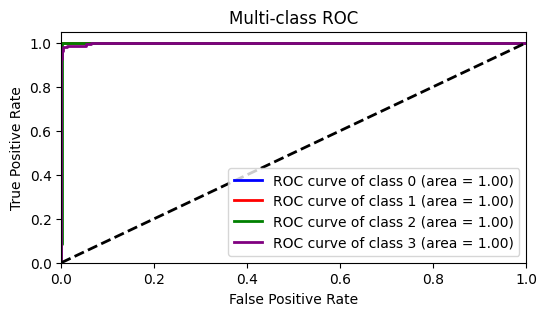

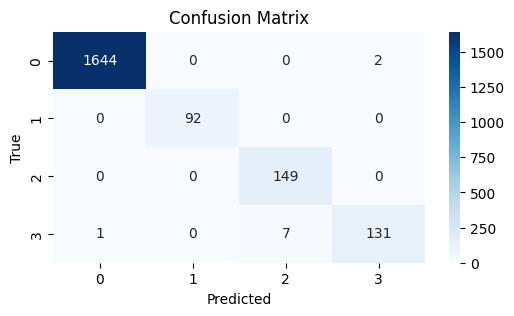

+--------------------------+----------------------+
|          Metric          |        Value         |
+--------------------------+----------------------+
| Training Time (seconds)  |  12.616138458251953  |
|         Accuracy         |  0.9950641658440277  |
|         F1 Score         |  0.9848432243543143  |
|        Precision         |  0.9848706771019201  |
|          Recall          |  0.985307744084198   |
|         AUC-ROC          |  0.9994740398825998  |
| Log Loss (Cross Entropy) | 0.016272709144094406 |
+--------------------------+----------------------+


In [ ]:
svm_clf_balanced = SVC(kernel='rbf', probability=True, random_state=123)
model_metrics['SVM_W/O_PCA_BALANCED'] = evaluate_model(svm_clf_balanced, X_train_balanced_scaled, y_train_resampled, X_test_scaled, y_test)

**Result Analysis**

1. **Training Time (12.6 seconds):**

  The model took approximately 12 seconds to train, which is reasonable and suggests efficiency, especially if the dataset is large or complex.

2. **Accuracy (99.51%):**

  A very high accuracy indicates that the model correctly predicts the class nearly 100% of the time. This is a significant improvement and suggests that balancing the dataset has positively impacted the model's ability to classify instances correctly.

3. **F1 Score (98.48%):**

  The F1 Score, which is the harmonic mean of precision and recall, is also exceptionally high. This suggests a well-balanced model in terms of precision and recall, and it indicates effective performance across all classes, especially important in a balanced dataset.

4. **Precision (98.48%) and Recall (98.53%):**

  Both precision and recall are similarly high, which is an ideal scenario. High precision means the model has a low false positive rate, and high recall indicates it correctly identifies most positive instances.

5. **AUC-ROC (99.95%):**

  This metric measures the model's ability to distinguish between classes. An AUC-ROC close to 1, as in this case, indicates excellent separability. It means the model can almost perfectly differentiate between classes.

6. **Log Loss (Cross Entropy) (0.016):**

  Log loss is a measure of error and lower values are better. A value close to 0, like this one, suggests that the model's predicted probabilities are highly accurate.

#### Random Forest

##### Random Forest with Principle Component Analysis & SMOTE

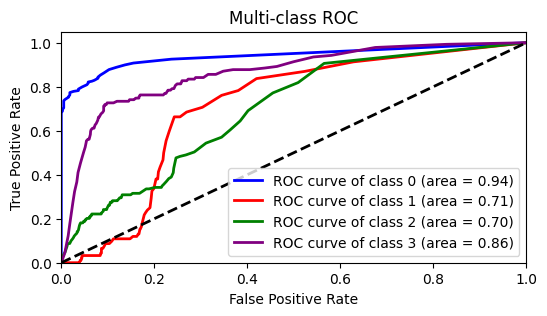

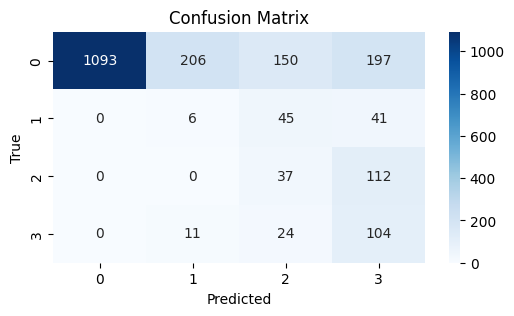

+--------------------------+--------------------+
|          Metric          |       Value        |
+--------------------------+--------------------+
| Training Time (seconds)  | 2.223341703414917  |
|         Accuracy         | 0.6120434353405726 |
|         F1 Score         | 0.342417909415749  |
|        Precision         | 0.3501279923660635 |
|          Recall          | 0.4314437499188696 |
|         AUC-ROC          | 0.8016165406497151 |
| Log Loss (Cross Entropy) | 3.4294094560398936 |
+--------------------------+--------------------+


In [ ]:
rf_model = RandomForestClassifier(random_state=123)
model_metrics['RF_PCA'] = evaluate_model(rf_model, X_train_pca, y_train_resampled, X_test_pca, y_test)

**Result Analysis:**

1. **Training Time (2.22 seconds):**

  The model trained relatively quickly, which is efficient, particularly if the dataset is large. Rapid training times are advantageous for iterative model tuning and experimentation.

2. **Accuracy (61.20%):**

  The accuracy, while moderate, suggests that the model correctly predicts the class over half the time. However, this metric alone might not fully capture the model's effectiveness, especially in the context of an imbalanced dataset.

3. **F1 Score (34.24%):**

  The F1 score, which balances precision and recall, is notably low. This suggests that the model has challenges in simultaneously achieving high precision and recall, indicating a potential trade-off between these metrics.

4. **Precision (35.01%) and Recall (43.14%):**

  Both precision and recall are moderate to low. Precision indicates how many of the model's positive predictions are correct, while recall shows how many actual positives the model correctly identifies. The relatively low values here suggest the model might be struggling to accurately classify all classes, particularly the minority class.

5. **AUC-ROC (80.16%):**

  A higher AUC-ROC score indicates a better model at distinguishing between classes. An AUC of over 80% is quite good and suggests that the model has a decent ability to differentiate between classes. However, this should be interpreted with caution given the other metrics.
  
6. **Log Loss (Cross Entropy) (3.43):**

  The log loss is relatively high, indicating that there are discrepancies between the predicted probabilities and the actual labels. Lower log loss values are preferable as they indicate better model performance.

##### Random Forest with unbalanaced dataset

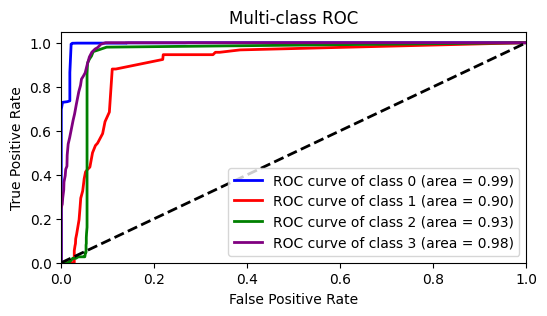

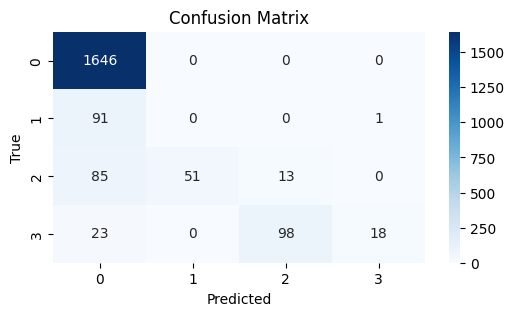

+--------------------------+---------------------+
|          Metric          |        Value        |
+--------------------------+---------------------+
| Training Time (seconds)  |  0.9497075080871582 |
|         Accuracy         |  0.8277393879565647 |
|         F1 Score         |  0.3177110943511163 |
|        Precision         |  0.4891566148947407 |
|          Recall          | 0.30418618125633723 |
|         AUC-ROC          |  0.951986986534828  |
| Log Loss (Cross Entropy) | 0.42951182000121546 |
+--------------------------+---------------------+


In [ ]:
rf_clf_balanced = RandomForestClassifier(random_state=123)
model_metrics['RF_W/O_PCA_IMBALANCED'] = evaluate_model(rf_clf_balanced, X_train_unbalanced_scaled, y_train, X_test_scaled, y_test)

**Result Analysis:**

1. **Training Time (0.95 seconds):**

  The model trained very quickly. This efficiency is beneficial, especially for large datasets or when multiple iterations are required for model tuning.

2. **Accuracy (82.77%):**

  The accuracy is relatively high, indicating the model correctly predicts the class around 83% of the time. However, high accuracy on an unbalanced dataset can sometimes be misleading if the model is biased towards the majority class.

3. **F1 Score (31.77%):**

  The F1 score is notably low compared to the accuracy. This discrepancy suggests the model is not equally effective across all classes, which is a common issue in unbalanced datasets. The F1 score is particularly important in such contexts because it considers both precision and recall.

4. **Precision (48.91%) and Recall (30.41%):**

  Both precision and recall are moderate to low. Low precision implies a significant number of false positives, while low recall indicates that the model is missing a substantial number of actual positives. This is especially concerning in unbalanced datasets where the minority class is often underrepresented.

5. **AUC-ROC (95.19%):**

  A high AUC-ROC score is generally indicative of a model's good performance in distinguishing between classes. However, this metric should be interpreted with caution in the context of an unbalanced dataset, as it can sometimes be artificially high if the model is good at identifying the majority class but poor at identifying the minority class.

6. **Log Loss (Cross Entropy) (0.429):**

  The log loss is moderate, suggesting that the model's predicted probabilities are somewhat aligned with the actual labels. Lower log loss values are better, as they indicate higher confidence and accuracy in the predictions.

##### Random Forest with balanaced dataset

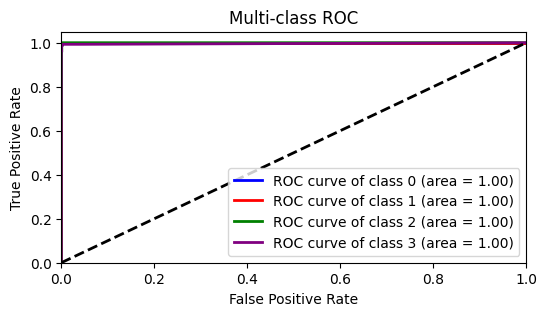

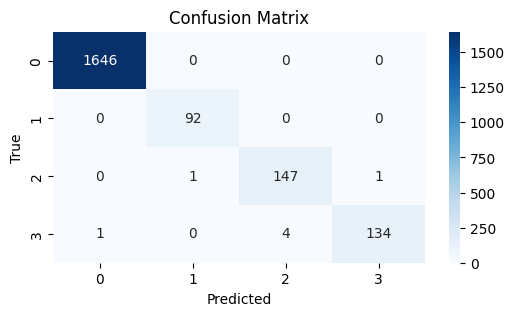

+--------------------------+----------------------+
|          Metric          |        Value         |
+--------------------------+----------------------+
| Training Time (seconds)  |  3.6635544300079346  |
|         Accuracy         |  0.9965449160908193  |
|         F1 Score         |  0.9880982774786596  |
|        Precision         |  0.9886856684134483  |
|          Recall          |  0.9876514895466177  |
|         AUC-ROC          |  0.9990068168653166  |
| Log Loss (Cross Entropy) | 0.025403019855312157 |
+--------------------------+----------------------+


In [ ]:
rf_clf_balanced = RandomForestClassifier(random_state=123)
model_metrics['RF_W/O_PCA_BALANCED'] = evaluate_model(rf_clf_balanced, X_train_balanced_scaled, y_train_resampled, X_test_scaled, y_test)

**Result Analysis:**

1. **Training (3.66 seconds):**

  The model demonstrates swift learning, completing training in under two seconds. This efficiency suggests good scalability for larger datasets and facilitates rapid iteration during model development.

2. **Accuracy (99.65%):**

  With an accuracy nearing perfection, the model shows an impressive ability to correctly classify instances. This level of accuracy is indicative of a well-tuned model, especially given the balanced nature of the dataset.

3. **F1 Score (98.81%):**

  The high F1 score indicates a harmonious balance between precision and recall. Such a score is particularly commendable in a balanced dataset, as it suggests equal adeptness in identifying positives across all classes without favoring one over another.

4. **High Precision (98.86%) and Recall (98.76%):**

  The model excels in both precision and recall, striking an ideal balance. High precision points to a low false positive rate, while high recall indicates successful identification of most positive cases. This equilibrium is crucial in balanced datasets where each class's accurate identification is vital.

5. **AUC-ROC (99.90%):**

  The AUC-ROC score is almost at its theoretical maximum, underscoring the model's exceptional ability to differentiate between classes. This suggests that the model not only makes accurate predictions but also does so with high confidence.

6. **Minimal Log Loss (0.025):**

  The low log loss reinforces the model's confidence in its predictions, aligning closely with the true outcomes. This is an excellent indicator of both the reliability and precision of the probability estimates provided by the model.

#### XGBoost

##### XGBoost with Principle Component Analysis & SMOTE

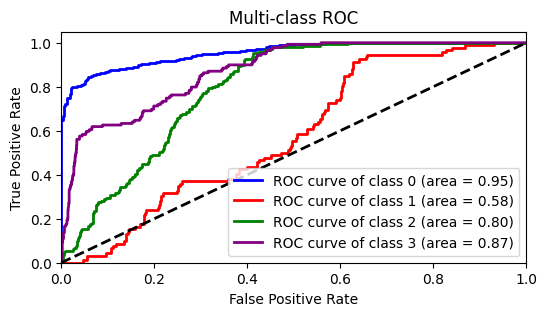

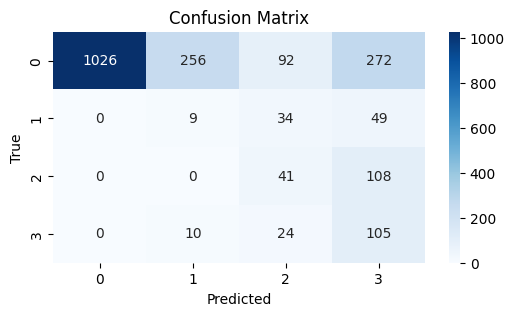

+--------------------------+---------------------+
|          Metric          |        Value        |
+--------------------------+---------------------+
| Training Time (seconds)  |   7.08422327041626  |
|         Accuracy         |  0.5829220138203356 |
|         F1 Score         | 0.34255563129720834 |
|        Precision         | 0.36100404301857325 |
|          Recall          |  0.4379297096888074 |
|         AUC-ROC          |  0.8017210152305996 |
| Log Loss (Cross Entropy) |  2.5806099327019876 |
+--------------------------+---------------------+


In [ ]:
xgb_model = XGBClassifier(random_state=123)
model_metrics['XGB_PCA'] = evaluate_model(xgb_model, X_train_pca, y_train_resampled, X_test_pca, y_test)

**Result Analysis:**

1. **Training Time (7.08 seconds):**

  The model trained relatively swiftly, which is beneficial for iterative tuning and larger datasets.

2. **Accuracy (58.29%):**

  Accuracy is moderate, indicating that the model correctly predicts the class about 60% of the time. This suggests room for improvement, especially considering the complexities introduced by PCA and SMOTE.

3. **F1 Score (34.25%):**

  The F1 score, balancing precision and recall, is fairly low. This indicates challenges in achieving a balance between false positives and false negatives, which is crucial in models trained on balanced datasets.

4. **Precision (36.10%) and Recall (43.79%):**

  Precision and recall are both moderate, with recall slightly higher. This suggests the model is somewhat better at identifying true positives but at the cost of increasing false positives.

5. **AUC-ROC (80.17%):**

  A relatively high AUC-ROC score suggests the model is decent at distinguishing between classes. However, this should be viewed in the context of the other metrics to get a complete picture of the model's performance.

6. **Log Loss (Cross Entropy) (2.58):**

  The higher log loss indicates discrepancies between the predicted probabilities and the actual labels. Lower log loss values are preferable.

##### XGBoost with unbalanaced dataset

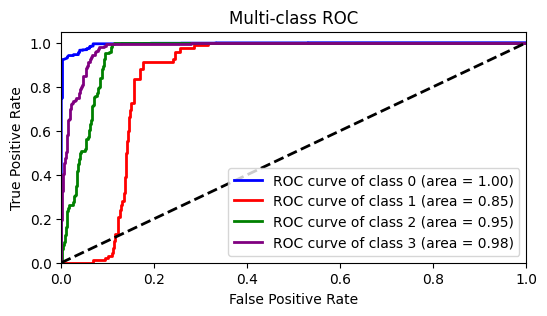

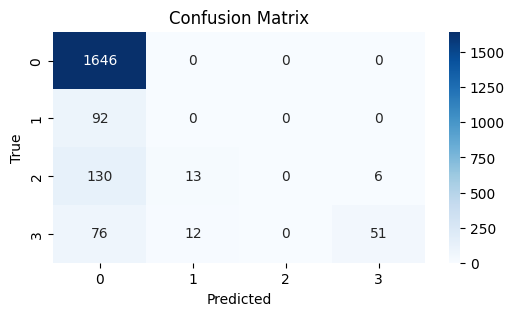

+--------------------------+---------------------+
|          Metric          |        Value        |
+--------------------------+---------------------+
| Training Time (seconds)  |  1.817451000213623  |
|         Accuracy         |  0.8376110562685094 |
|         F1 Score         |  0.3593499516798363 |
|        Precision         |  0.6853611652588261 |
|          Recall          | 0.34172661870503596 |
|         AUC-ROC          |  0.9444228131890368 |
| Log Loss (Cross Entropy) |  1.022160161491895  |
+--------------------------+---------------------+


In [ ]:
xgb_clf_balanced = XGBClassifier(random_state=123)
model_metrics['XGB_W/O_PCA_IMBALANCED'] = evaluate_model(xgb_clf_balanced, X_train_unbalanced_scaled, y_train, X_test_scaled, y_test)

1. **Efficient Training (1.81 seconds):**

  The model demonstrates an 1.81 seconds of training time, which is advantageous for efficient iterations and scalability to larger datasets.

2. **Good Accuracy (83.76%):**

  A high accuracy rate suggests the model correctly predicts the class in about 84% of cases. However, in the context of an unbalanced dataset, this might be influenced by the model's performance on the majority class rather than a balanced performance across all classes.

3. **Low F1 Score (35.93%):**

  The F1 score, which harmonizes precision and recall, is significantly lower than the accuracy. This disparity indicates the model may be struggling to balance false positives and false negatives effectively, a typical challenge in unbalanced datasets.

4. **High Precision (68.53%), Low Recall (34.17%):**

  The model has high precision, meaning when it predicts a class, it is correct a significant proportion of the time. However, the low recall suggests the model is missing a substantial number of actual positives, especially within the minority class.

5. **High AUC-ROC (94.44%):**

  A high AUC-ROC score is indicative of the model's strong ability to differentiate between classes. It suggests that the model is better at ranking predictions than making definitive class assignments.

6. **Moderate Log Loss (1.02):**

  The log loss is moderate, indicating that there are some discrepancies between the predicted probabilities and the actual labels. A lower log loss would be preferable for a more confident and accurate model.

##### XGBoost with balanaced dataset

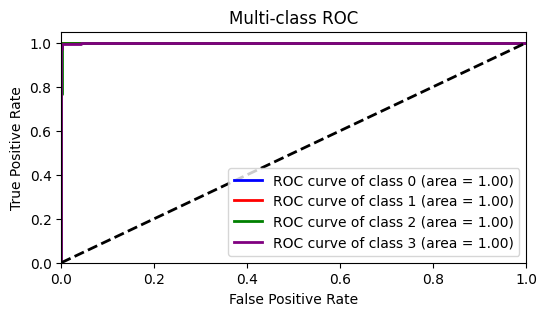

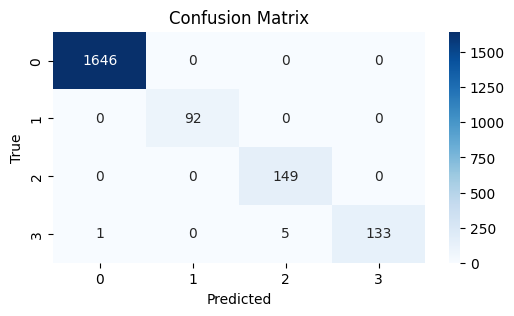

+--------------------------+----------------------+
|          Metric          |        Value         |
+--------------------------+----------------------+
| Training Time (seconds)  |  0.7594244480133057  |
|         Accuracy         |  0.9970384995064165  |
|         F1 Score         |  0.9902839629611485  |
|        Precision         |  0.9917313257477192  |
|          Recall          |  0.9892086330935252  |
|         AUC-ROC          |  0.9998804867535194  |
| Log Loss (Cross Entropy) | 0.011380928639411128 |
+--------------------------+----------------------+


In [ ]:
xgb_clf_balanced = XGBClassifier(random_state=123)
model_metrics['XGB_W/O_PCA_BALANCED'] = evaluate_model(xgb_clf_balanced, X_train_balanced_scaled, y_train_resampled, X_test_scaled, y_test)

1. **Training Time (0.76 seconds):**

  The model took a small amount of time to train, which is reasonable considering the complexity and effectiveness of XGBoost algorithms.

2. **Excellent Accuracy (99.70%):**

  The model achieves near-perfect accuracy, indicating it is highly effective at making correct predictions. This high accuracy is particularly significant in a balanced dataset, suggesting the model performs well across all classes.

3. **High F1 Score (99.02%):**

  The F1 score, which combines precision and recall, is also exceptionally high. This indicates the model maintains a strong balance between identifying true positives and avoiding false positives.

4. **Outstanding Precision (99.17%) and Recall (98.92%):**

  Both precision and recall are remarkably high. High precision indicates the model's predictions are reliable, while high recall shows it is effectively identifying the majority of actual positive cases.

5. **Superior AUC-ROC (99.98%):**

  A nearly perfect AUC-ROC score suggests the model has an excellent ability to distinguish between classes. It indicates a very high degree of confidence in its predictions.

6. **Very Low Log Loss (0.0113):**

  The low log loss score reflects the model's high confidence and accuracy in its probability predictions.

#### Gradient Boosting Machines (GBM)

##### Gradient Boosting with Principle Component Analysis & SMOTE

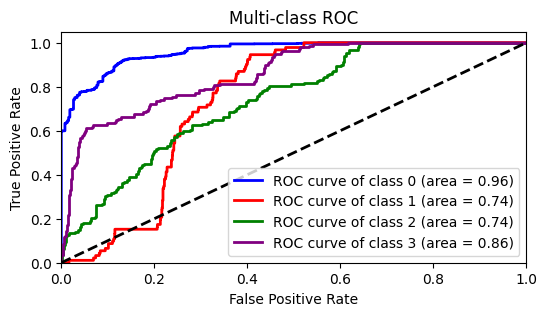

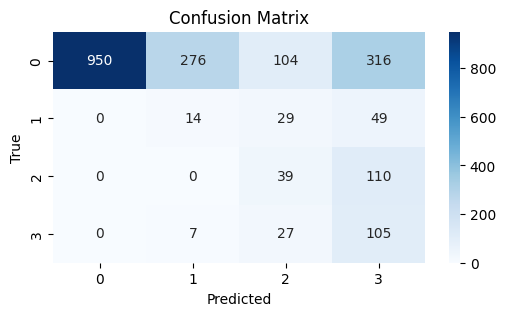

+--------------------------+---------------------+
|          Metric          |        Value        |
+--------------------------+---------------------+
| Training Time (seconds)  |  15.835301160812378 |
|         Accuracy         |  0.5468904244817374 |
|         F1 Score         | 0.33002122789320154 |
|        Precision         | 0.35603810734853886 |
|          Recall          |  0.436617826640142  |
|         AUC-ROC          |  0.8259773037580567 |
| Log Loss (Cross Entropy) |  1.717004991247105  |
+--------------------------+---------------------+


In [ ]:
gbm_model = GradientBoostingClassifier(random_state=123)
model_metrics['GB_PCA'] = evaluate_model(gbm_model, X_train_pca, y_train_resampled, X_test_pca, y_test)

1. **Extended Training Time (15.83 seconds):**

  The model's training duration is longer compared to other models, which may be due to the complexity of the GBM algorithm combined with the data processing steps (PCA and SMOTE).

2. **Moderate Accuracy (54.68%):**

  The accuracy is just over half, indicating the model correctly predicts the class slightly more than half the time. This level is relatively low, especially in the context of a dataset that has been balanced and dimensionally reduced.

3. **Low F1 Score (33.00%):**

  The F1 score, a balance of precision and recall, is considerably low. This suggests challenges in achieving a harmonious balance between the false positives and false negatives.

4. **Moderate Precision (35.60%) and Recall (43.66%):**

  Both precision and recall are moderate, with recall being slightly higher. This indicates the model is somewhat better at identifying true positives but struggles with a higher rate of false positives and false negatives.

5. **Good AUC-ROC (82.59%):**

  A relatively high AUC-ROC score implies the model has a decent ability to differentiate between classes. This is a positive aspect but needs to be interpreted in light of other metrics.

6. **High Log Loss (1.72):**

  The higher log loss indicates significant discrepancies between the predicted probabilities and actual values, suggesting room for improvement in the model's confidence and accuracy in its predictions.

##### Gradient Boosting with unbalanaced dataset

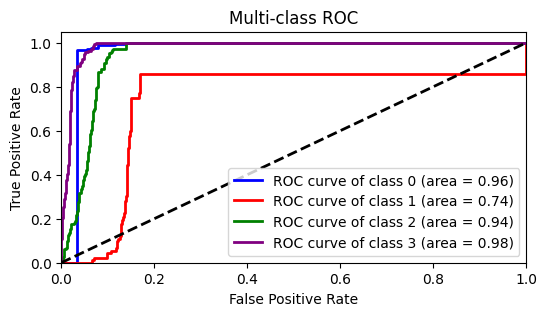

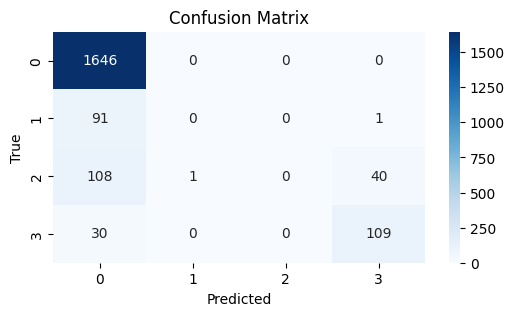

+--------------------------+--------------------+
|          Metric          |       Value        |
+--------------------------+--------------------+
| Training Time (seconds)  | 9.661805868148804  |
|         Accuracy         | 0.866238894373149  |
|         F1 Score         | 0.4223217295338203 |
|        Precision         | 0.6511333333333333 |
|          Recall          | 0.4460431654676259 |
|         AUC-ROC          | 0.907032483210076  |
| Log Loss (Cross Entropy) | 0.9221980335098181 |
+--------------------------+--------------------+


In [ ]:
gbm_clf_unbalanced = GradientBoostingClassifier(random_state=123)
model_metrics['GB_W/O_PCA_IMBALANCED'] = evaluate_model(gbm_clf_unbalanced, X_train_unbalanced_scaled, y_train, X_test_scaled, y_test)

1. **Training Time (9.66 seconds):**

  The training time is moderate, reflecting the inherent complexity and computational intensity of GBM algorithms. This is acceptable, especially for high-dimensional datasets or complex models.

2. **Good Accuracy (86.62%):**

  The model achieves a high accuracy rate, suggesting effective overall predictions. However, in unbalanced datasets, accuracy can be misleading as it might be predominantly influenced by the majority class.

3. **Moderate F1 Score (42.23%):**

  The F1 score, which balances precision and recall, is moderate and significantly lower than the accuracy. This indicates challenges in achieving a balance between false positives and false negatives, particularly in the context of an unbalanced dataset.

4. **High Precision (65.11%), Moderate Recall (44.60%):**

  Precision is high, indicating the model has a lower rate of false positives. However, the moderate recall suggests the model is missing a significant number of true positives, especially within the minority class.

5. **Strong AUC-ROC (90.70%):**

  A high AUC-ROC score implies that the model is quite effective at distinguishing between classes. However, like accuracy, this should be considered cautiously in unbalanced datasets.

6. **High Log Loss (0.92):**

  The log loss is relatively high, indicating that the predicted probabilities have notable discrepancies from the actual labels. Lower log loss values are preferable as they indicate a more accurate and confident model.

##### Gradient Boosting with balanaced dataset

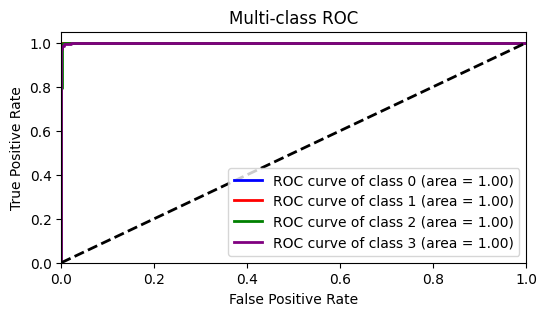

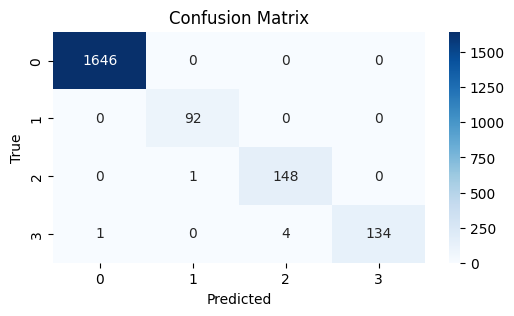

+--------------------------+---------------------+
|          Metric          |        Value        |
+--------------------------+---------------------+
| Training Time (seconds)  |  26.54240369796753  |
|         Accuracy         |  0.9970384995064165 |
|         F1 Score         |  0.9898411515343839 |
|        Precision         |  0.9905810894531705 |
|          Recall          |  0.9893293418956111 |
|         AUC-ROC          |  0.9999065174901569 |
| Log Loss (Cross Entropy) | 0.00897753853652435 |
+--------------------------+---------------------+


In [ ]:
gbm_clf_balanced = GradientBoostingClassifier(random_state=123)
model_metrics['GB_W/O_PCA_BALANCED'] = evaluate_model(gbm_clf_balanced, X_train_balanced_scaled, y_train_resampled, X_test_scaled, y_test)

1. **Extended Training Time (26.54 seconds):**

  The model exhibits a longer training duration, likely due to the computational demands of GBM algorithms and the balanced nature of the dataset. This extended time is justifiable considering the resulting high performance.

2. **Accuracy (99.70%):**

  With near-perfect accuracy, the model demonstrates excellent predictive capability, correctly identifying the class in almost every instance. This level of accuracy, particularly in a balanced dataset, is indicative of a highly effective model.

3. **F1 Score (98.98%):**

  The F1 score, which harmonizes precision and recall, is remarkably high. This suggests a near-perfect balance in the model's ability to correctly identify positive cases while minimizing false positives.

4. **High Precision (99.06%) and Recall (98.93%):**

  Both precision and recall are impressively high, reflecting the model's accuracy and reliability. High precision suggests few false positives, while high recall indicates effective identification of true positives.

5. **AUC-ROC (99.99%):**

  The AUC-ROC score is nearly at the maximum possible value, signifying the model's superior ability to distinguish between classes. This demonstrates that the model not only makes accurate class predictions but does so with high confidence.

6. **Minimal Log Loss (0.0089):**

  The very low log loss indicates that the model's probability predictions are highly accurate and closely align with the actual class labels.